# QSARtuna CLI Tutorial

step1,超参数优化：使用Optuna搜索最佳模型配置（only training set  
step2,模型构建：使用最佳配置构建模型并在测试集上评估（only training set  
step3,生产构建：在合并的训练和测试数据上重新训练最终模型（training + test  

### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [1]:
import sys
sys.path.append(".")

In [2]:
# Start with the imports.
import sklearn
import numpy
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP, Avalon, JazzyDescriptors, PhyschemDescriptors

#### FOR REGRESSION：

In [133]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="SMILES",  # Typical names are "SMILES" and "smiles".
        response_column="active",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./trainset.csv",
        test_dataset_file="./testset.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new()
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        KNeighborsRegressor.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,  # Total number of trials.
        n_startup_trials=50,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

#### FOR CLASSIFICATION：

In [3]:
from optunaz.config.optconfig import ChemPropHyperoptClassifier, ChemPropClassifier, RandomForestClassifier, CalibratedClassifierCVWithVA, SVC, LogisticRegression, KNeighborsClassifier
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile

config = OptimizationConfig(
    data=Dataset(
        input_column="smiles (Canonical)",  # Typical names are "SMILES" and "smiles".
        response_column="active",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./trainset.csv",
        test_dataset_file="./testset-nodup.csv"  # Hidden during optimization.
    ),
    descriptors=[
        SmilesFromFile.new(),
#        ECFP.new(),
#        ECFP_counts.new(),
#        MACCS_keys.new(),
#        PathFP.new(),
#        Avalon.new(),
#        JazzyDescriptors.new(), 
#        PhyschemDescriptors.new()
    ],
    algorithms=[
        ChemPropHyperoptClassifier.new( #Hyperopt自动优化参数
            epochs=50, #训练几个batch，1个batch中，通过设置batch size控制多少次迭代遍历所有样本
            ensemble_size=5, #控制创建多少个具有不同权重初始化的模型
            num_iters=10, #参数优化次数
            features_generator=["rdkit_2d_normalized"], #生成额外特征
            search_parameter_level=["6"] #自动优化级别，6包含batch_size优化 
        )
#        RandomForestClassifier.new(n_estimators={"low": 100, "high": 200}),
#        CalibratedClassifierCVWithVA.new(
#            estimator=RandomForestClassifier.new(
#                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
#                    low=100, high=200
#                )
#            ),
#            n_folds=5,
#            ensemble="True",
#            method="sigmoid", 
#        ),
#        SVC.new(), 
#        LogisticRegression.new(), 
#        KNeighborsClassifier.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=10, #1为禁用交叉验证，5平衡，10慢/小数据使用
        n_trials=100, # run only one random forest classifier trial
        n_startup_trials=50,
        n_chemprop_trials=5, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=True, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

### Run optimization

In [4]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = True # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [5]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2025-05-27 17:07:12,537] A new study created in memory with name: my_study
[I 2025-05-27 17:07:12,595] A new study created in memory with name: study_name_0
[I 2025-05-27 20:57:50,113] Trial 0 finished with value: 0.8493026718245374 and parameters: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}. Best is trial 0 with value: 0.8493026718245374.
[I 2025-05-27 20:57:50,118] Trial 1 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,123] Trial 2 pruned. Duplicate p

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

[I 2025-05-27 20:57:50,322] Trial 32 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,331] Trial 33 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,340] Trial 34 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,349] Trial 35 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,358] Trial 36 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,368] Trial 37 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,377] Trial 38 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,387] Trial 39 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,397] Trial 40 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,407] Trial 41 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,417] Trial 42 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,427] Trial 43 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,438] Trial 44 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,448] Trial 45 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,459] Trial 

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

[I 2025-05-27 20:57:50,538] Trial 53 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,550] Trial 54 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,562] Trial 55 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,575] Trial 56 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,587] Trial 57 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,600] Trial 58 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,613] Trial 59 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,626] Trial 60 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,639] Trial 61 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,652] Trial 62 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,665] Trial 63 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,678] Trial 64 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,693] Trial 65 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,707] Trial 66 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,720] Trial 

Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

[I 2025-05-27 20:57:50,749] Trial 69 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,764] Trial 70 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,778] Trial 71 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,794] Trial 72 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,809] Trial 73 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,824] Trial 74 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,839] Trial 75 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,855] Trial 76 pruned. Duplicate parameter set
[I 2025-05-27 20:57:50,870] Trial 77 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

[I 2025-05-27 20:57:51,052] Trial 78 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,069] Trial 79 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,093] Trial 80 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,110] Trial 81 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,126] Trial 82 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,142] Trial 83 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,159] Trial 84 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,175] Trial 85 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,191] Trial 86 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,208] Trial 87 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,225] Trial 88 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,242] Trial 89 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

[I 2025-05-27 20:57:51,260] Trial 90 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,277] Trial 91 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,294] Trial 92 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,312] Trial 93 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,329] Trial 94 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,347] Trial 95 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,365] Trial 96 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,384] Trial 97 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,412] Trial 98 pruned. Duplicate parameter set
[I 2025-05-27 20:57:51,434] Trial 99 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>, 'num_iters__21e5e34ad5fefedb1cbadb73f575b041': 10, 'search_parameter_level__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropSearch_Parameter_Level.L6: '6'>, 'descriptor': '{"name": "SmilesFromFile", "parameters": {}}'}, return [0.8493026718245374]
Duplicated trial: {'algorithm_name': 'ChemPropHyperoptClassifier', 'ChemPropHyperoptClassifier_algorithm_hash': '21e5e34ad5fefedb1cbadb73f575b041', 'ensemble_size__21e5e34ad5fefedb1cbadb73f575b041': 5, 'epochs__21e5e34ad5fefedb1cbadb73f575b041': 50, 'features_generator__21e5e34ad5fefedb1cbadb73f575b041': <ChemPropFeatures_Generator.RDKIT_2D_NORMALIZED: 'rdkit_2d_normalized'>

### Visualize optimization progress

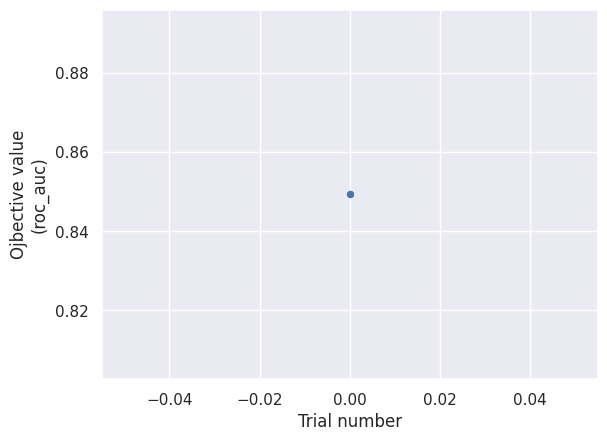

In [6]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

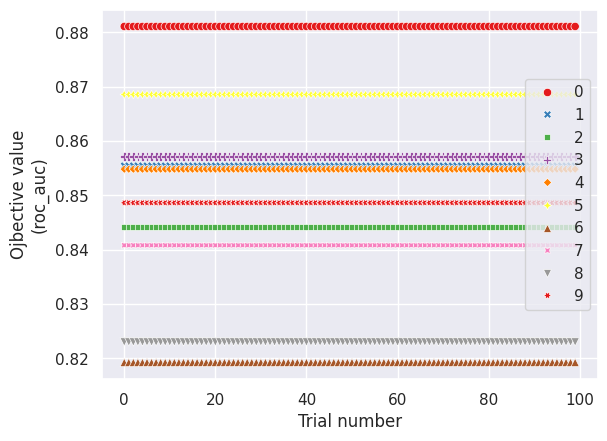

In [7]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

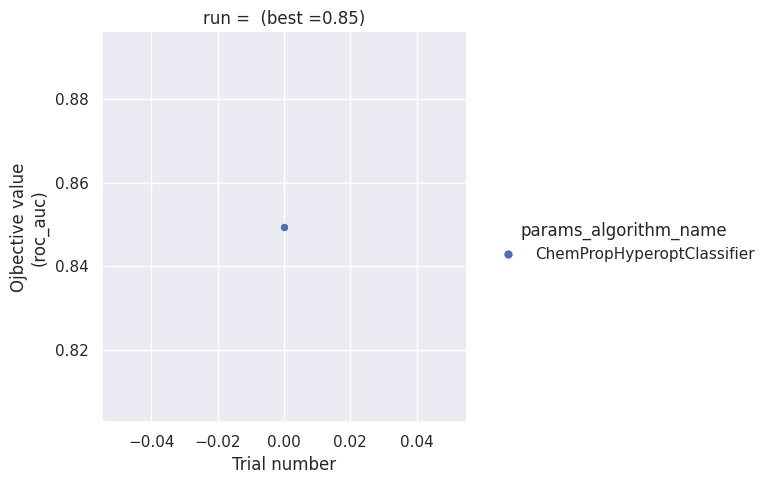

In [8]:
import seaborn as sns

comparison = study.trials_dataframe().assign(run=f' (best ={study.best_value:.2f})')

default_reg_scoring= config.settings.scoring
ax = sns.relplot(data=comparison, x="number", y="value", 
                 col='run',hue='params_algorithm_name', 
                 facet_kws={"sharey":False})
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
ax.tight_layout()

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [9]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [ ]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

with open("best_buildconfig.json", 'w') as f:
    json.dump(buildconfig_as_dict, f, indent=2)

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [10]:
best_build = build_best(buildconfig, "./best.pkl")

Now we can explore how good the best model performs on the test (holdout) set.

In [11]:
import pickle
with open("./best.pkl", "rb") as f:
    model_best = pickle.load(f)
model_best.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([0.22852682, 0.15165497])

In [12]:
import pandas as pd

df_best = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_best = df_best[config.data.response_column]
predicted_best = model_best.predict_from_smiles(df_best[config.data.input_column])
#model_best.predict_from_smiles(df_best[config.data.input_column], explain=True) #explain

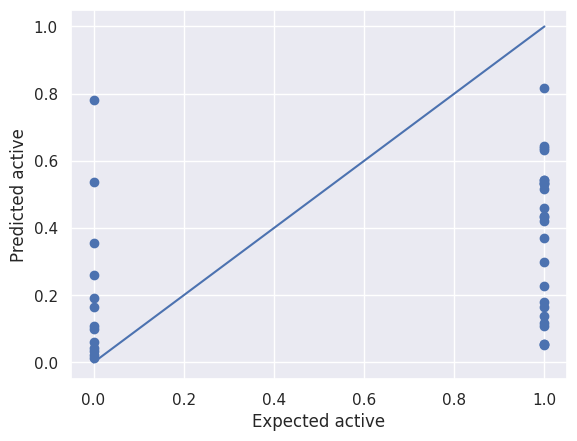

In [13]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_best, predicted_best)
lims = [expected_best.min(), expected_best.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [19]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_best, y_pred=predicted_best)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_best, y_pred=predicted_best))  

# MAE
mae = mean_absolute_error(y_true=expected_best, y_pred=predicted_best)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8157316103919156, RMSE: 0.21324421208055416, Mean absolute error: 0.16504434020284356


If the metrics look acceptable, the model is ready for use.

In [14]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_best, y_score=predicted_best)   
print(f"RMSE: {roc_auc}")

RMSE: 0.7353846153846154


### Build merged model

if here is more data available in testset:

In [ ]:
# 1. 加载之前保存的buildconfig  
with open("best_buildconfig.json", "r") as f:  
    buildconfig = deserialize(BuildConfig, json.load(f))  
# 2. 修改数据集路径  
buildconfig.data.test_dataset_file = "new_combined_dataset.csv"  

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [143]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "./merged.pkl")

In [5]:
import pickle
with open("./merged.pkl", "rb") as f:
    model_merged = pickle.load(f)
model_merged.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([0.87492206, 0.1888582 ])

In [15]:
import pandas as pd

df_merged = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_merged = df_merged[config.data.response_column]
predicted_merged = model_merged.predict_from_smiles(df_merged[config.data.input_column])
model_merged.predict_from_smiles(df_merged[config.data.input_column], explain=True) #explain

,shap_value,descriptor,bit,info
428,0.034305,ECFP_counts,428,c(C)(c)c
820,0.028178,ECFP_counts,820,c(nc)(C#N)nc
679,0.025554,ECFP_counts,679,C(c(n)n)#N
857,0.018138,ECFP_counts,857,c(-c)(c)c
1466,0.016487,ECFP_counts,1466,N(C(c)=O)C(C)c
...,...,...,...,...
1074,0.000000,ECFP_counts,1074,c(C)(cc)n[nH]
1071,0.000000,ECFP_counts,1071,C(C)(CC)C(C)C
1070,0.000000,ECFP_counts,1070,
1069,0.000000,ECFP_counts,1069,c(c(C)c)(c(c)O)C=O


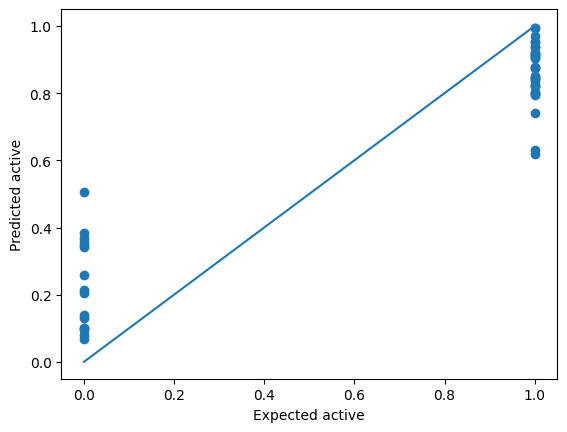

In [16]:
# Plot expected vs predicted values for the merged model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_merged, predicted_merged)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

In [11]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_merged, y_pred=predicted_merged)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_merged, y_pred=predicted_merged))  

# MAE
mae = mean_absolute_error(y_true=expected_merged, y_pred=predicted_merged)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8337219008284099, RMSE: 0.2025673084937264, Mean absolute error: 0.130254857361105


In [17]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_merged, y_score=predicted_merged)   
print(f"RMSE: {roc_auc}")

RMSE: 1.0


### USE MODLE

In [31]:
import pickle
with open("./best.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([0.10075457, 0.14849992])

In [32]:
df = pd.read_csv('concat-AKT-20250522.csv')  # Load data.

predicted = model.predict_from_smiles(df['SMILES'])
print(predicted)

[0.58013228 0.51242073 0.59398386 ... 0.28128365 0.21121606 0.38663395]


In [13]:
df['qsar'] = predicted

In [14]:
df.to_csv('concat-AKT-20250522.csv')